## IMPORTS

In [831]:
import random
import numpy as np 
import pandas as pd 
import ast
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
# import scipy.stats as stats
# from matplotlib.ticker import PercentFormatter
from scipy.stats import zscore

import re
import string
from functools import lru_cache
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from joblib import Parallel, delayed
from sklearn.preprocessing import MinMaxScaler
# nltk.download('vader_lexicon')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

## Análisis de sentimientos

In [832]:
# Inicializar el analizador de sentimiento de NLTK
# sid = SentimentIntensityAnalyzer()

# Función para normalizar el compound score (rango [-1,1]) a un rango de 1 a 10
# def normalize_sentiment(compound_score):
    # Mapear: -1 --> 1 y 1 --> 10
    # return ((compound_score + 1) / 2) * 9 + 1

# Aplicar análisis de sentimiento a cada comentario y normalizarlo
# df['sentiment'] = df['comment'].apply(lambda x: sid.polarity_scores(x)['compound'])
# df['sentiment_normalized'] = df['sentiment'].apply(normalize_sentiment)
# df.head(5)

## Métodos necesarios

In [833]:

# Reemplaza los valores atípicos que pueden generar confusión a la hora de entrenar el modelo ML
def arreglar_dispersion(df, columnas, z_score_umbral):
    for col in columnas:
        # Z-score es mide cuántas desviaciones estándar se encuentra un valor respecto a la media.
        z_scores = np.abs(zscore(df[col], nan_policy='omit'))  # Calcula Z-score
        df.loc[z_scores > z_score_umbral, col] = np.nan  # Sustituye atípicos con NaN


In [834]:
def comprobar_dispersion(df, cols):
    z_scores = df[cols].apply(zscore)

# Contar cuántos valores atípicos hay en cada columna (valores con |Z-score| > 3)
    outlier_counts = (abs(z_scores) > 3).sum()

# Mostrar columnas con valores atípicos
    print(outlier_counts[outlier_counts > 0].sort_values(ascending=False))

In [835]:
def limpiador_nombres(df_a_limpiar):
    # Limpiar nombres de columnas: convertir a minúsculas y reemplazar espacios por '_'
    
    df_a_limpiar.columns = df_a_limpiar.columns.str.lower().str.replace(' ', '_')

    return df_a_limpiar

## Código

### Constantes

In [836]:
# Columnas seleccionas del dataset con la información de los juegos
INFO_JUEGO_COLS = ['id',
                   'primary',
                   'yearpublished',
                   'playingtime',
                   'boardgamecategory', 
                   'maxplayers',
                   'average']

# Columans seleccionadas de las reviews
RATING_COLS = ['user',
               'rating',
               'ID', 
               'comment']

PROBABILIDAD_FALLO = 0.2
TOP_JUEGOS = 1000
PORCENTAJE = 0.1
VOTOS_MINIMOS = 10
DELIMITADOR_Z_SCORE = 3
EJEMPLO_USUARIO = "1000rpm"
VALORACION_USUARIO_UMBRAL = 5


FILTRO_CATEGORIA = {
    "boardgamecategory": None
}
FILTRO_NUMERICO = {
    "playingtime": None,
    "average": {"measure": "above", "threshold": 7}
}


In [837]:
# Semilla aleatoria utilizando el tiempo del sistema
random.seed(int(time.time()))
# Permite transdformar los usuarios a números enteros
label_encoder = LabelEncoder()

# Para mostrar datos de forma gráfica
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [838]:
# Lectura CSV
info_juegos = pd.read_csv("../data/games_detailed_info.csv",
        usecols=INFO_JUEGO_COLS, 
        dtype={'id': 'uint32', 
                'primary': 'string', 
                'yearpublished': 'uint16', 
                'maxplayers': 'uint16',
                'playingtime': 'uint32',
                'average': 'float16'
                })


# Solucionar dispersión, sustituye por nan
arreglar_dispersion(info_juegos, ['playingtime', 'maxplayers'], DELIMITADOR_Z_SCORE)

# Eliminar nulos, duplicados.
info_juegos = info_juegos.dropna()
info_juegos = info_juegos.drop_duplicates()

#  Eliminar espacios en blanco
info_juegos['primary'] = info_juegos['primary'].str.lower()
info_juegos['primary'] = info_juegos['primary'].str.replace(' ', '_')
info_juegos['average'] = info_juegos['average'].apply(lambda x: np.around(x, decimals=2))

In [839]:
# info_juegos.info()
# info_juegos.isnull().values.any()
# info_juegos.isnull().sum().sum()
# info_juegos.head(10)
info_juegos.head()

,id,primary,yearpublished,maxplayers,playingtime,boardgamecategory,average
0,30549,pandemic,2008,4.0,45.0,['Medical'],7.59
1,822,carcassonne,2000,5.0,45.0,"['City Building', 'Medieval', 'Territory Build...",7.42
2,13,catan,1995,4.0,120.0,"['Economic', 'Negotiation']",7.14
3,68448,7_wonders,2010,7.0,30.0,"['Ancient', 'Card Game', 'City Building', 'Civ...",7.73
4,36218,dominion,2008,4.0,30.0,"['Card Game', 'Medieval']",7.61


In [840]:
info_juegos.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 21097 entries, 0 to 21630
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 21097 non-null  uint32 
 1   primary            21097 non-null  string 
 2   yearpublished      21097 non-null  uint16 
 3   maxplayers         21097 non-null  float64
 4   playingtime        21097 non-null  float64
 5   boardgamecategory  21097 non-null  object 
 6   average            21097 non-null  float64
dtypes: float64(3), object(1), string(1), uint16(1), uint32(1)
memory usage: 4.2 MB


In [841]:
reviews = pd.read_csv("../data/bgg-26m-reviews.csv", 
                      usecols=RATING_COLS, 
                      skiprows=lambda x: x > 0 and random.random() >= PROBABILIDAD_FALLO,
                      dtype={'user': 'string', 
                             'rating': 'float16', 
                             'ID': 'uint32',
                             'comment': 'string[pyarrow]' #  Al usar string[pyarrow] se reduce la memoria significativamente
                             }) 

reviews = reviews.dropna()
reviews = reviews.drop_duplicates(subset=["user", "ID"], keep="first")

reviews['rating'] = reviews['rating'].astype(np.int8)

In [842]:
reviews.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 842690 entries, 1 to 5242076
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user     842690 non-null  string
 1   rating   842690 non-null  int8  
 2   comment  842690 non-null  string
 3   ID       842690 non-null  uint32
dtypes: int8(1), string(2), uint32(1)
memory usage: 244.2 MB


In [843]:
reviews.memory_usage(deep=True)

Index        6741520
user        55579561
rating        842690
comment    189531922
ID           3370760
dtype: int64

In [844]:
reviews.head()

,user,rating,comment,ID
1,dougthonus,10,"Currently, this sits on my list as my favorite...",13
4,hurkle,10,Fantastic game. Got me hooked on games all ove...,13
5,Thesp,10,One of the best games ever created. Period. Ne...,13
7,PatB,10,Settlers is a gem. If you havn't played it I s...,13
9,ScottM,10,"Everyone I've shown this to, gamer and non-gam...",13


In [845]:
# Filtra por los registros que coinciden con el id de info_juegos
reviews = reviews[reviews['ID'].isin(info_juegos['id'])]
reviews.head(4)

,user,rating,comment,ID
1,dougthonus,10,"Currently, this sits on my list as my favorite...",13
4,hurkle,10,Fantastic game. Got me hooked on games all ove...,13
5,Thesp,10,One of the best games ever created. Period. Ne...,13
7,PatB,10,Settlers is a gem. If you havn't played it I s...,13


In [846]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 788443 entries, 1 to 5242049
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user     788443 non-null  string
 1   rating   788443 non-null  int8  
 2   comment  788443 non-null  string
 3   ID       788443 non-null  uint32
dtypes: int8(1), string(2), uint32(1)
memory usage: 182.4 MB


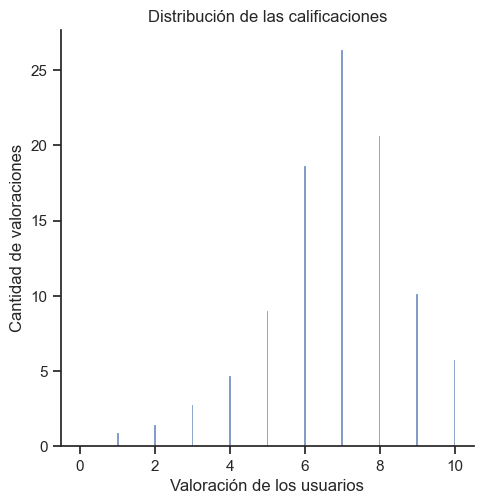

In [847]:
ax = sns.displot(data=reviews, x='rating', stat='percent', fill="blue")
ax.set(xlabel="Valoración de los usuarios",
       ylabel='Cantidad de valoraciones',
       title='Distribución de las calificaciones')

In [848]:
# Genera una tabla agrupando por id de juego y mostrando el número de usuarios que han valorado el juego y la media total de la valoración.
rated_games = reviews.groupby("ID").agg({"rating": "mean", "user": "count"}).reset_index()
rated_games.sort_values("rating", ascending=False)

,ID,rating,user
8911,57183,10.0,1
18940,284987,10.0,1
7038,25924,10.0,1
15774,217270,10.0,3
15649,213834,10.0,2
...,...,...,...
3754,6959,1.0,1
18639,277565,1.0,2
14115,182681,1.0,1
5080,11680,1.0,1


### Sistema de recomendación colaborativo.
Sistema de recomendación colaborativo basado en juegos similiares que el usuario valoró positivamente.

In [849]:
# Ordenado por juego con mayor cantidad de usuarios que han valorado dicho juego
#rated_games = rated_games.sort_values(by='user', ascending=False).head(TOP_JUEGOS)
rated_games.head()

,ID,rating,user
0,1,7.435540,287
1,2,6.446809,47
2,3,7.428571,707
3,4,6.666667,18
4,5,7.450734,954


Filtrado de aquellos juegos que tengan una cantidad mínima de votos para evitar juegos con pocas valoraciones, lo que podría ser menos confiable

In [850]:
# Media de reviews 
MEDIA_VOTOS = int(rated_games['user'].mean())

# Cantidad de votos que superan la media.
votos_superan_media = (rated_games['user'] >= MEDIA_VOTOS).sum()

# Cantidad de votos que deben superar el mínimo de votos.
MIN_JUEGOS = int(len(info_juegos) * PORCENTAJE)

# Número de juegos que se van a seleccionar.
SELECCION = int(votos_superan_media * 0.3)

print(MIN_JUEGOS)
print(votos_superan_media)

# Se filtra según los votos y la cantidad de reviews que supera el mínimo de reviews.
if MEDIA_VOTOS > 0 and votos_superan_media > MIN_JUEGOS:
    rated_games = rated_games[rated_games["user"] >= MEDIA_VOTOS].head(SELECCION) # Se toma solo un porcentaje de todas las reviews.
    

sample_reviews = reviews[reviews['ID'].isin(rated_games['ID'])]
sample_reviews.count()


2109
3640


user       205689
rating     205689
comment    205689
ID         205689
dtype: int64

In [851]:
sample_reviews.head()

,user,rating,comment,ID
1,dougthonus,10,"Currently, this sits on my list as my favorite...",13
4,hurkle,10,Fantastic game. Got me hooked on games all ove...,13
5,Thesp,10,One of the best games ever created. Period. Ne...,13
7,PatB,10,Settlers is a gem. If you havn't played it I s...,13
9,ScottM,10,"Everyone I've shown this to, gamer and non-gam...",13


In [852]:
sample_reviews.memory_usage(deep=True)

Index       1645512
user       13533618
rating       205689
comment    39115383
ID           822756
dtype: int64

#### Matriz de interacción
Creación de la matriz de interacción donde el índice es el nombre del usuario, las columnas son los juegos y los valores son las valoraciones de dichos juegos por un usuario concreto

In [853]:
# Creación de la matriz de interacción. x = ID, y = user, valor = rating
games_matrix = sample_reviews.pivot_table(index='user', columns='ID', values='rating')

# Se rellenan los nulos con ceros para cálculos posteriores.
# games_matrix.fillna(0) 
games_matrix.head()


ID,1,2,3,5,7,9,10,11,12,13,...,20100,20133,20134,20437,20542,20545,20551,20806,20847,20865
user,,,,,,,,,,,,,,,,,,,,,
-Johnny-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,...,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-LucaS-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-mIDE-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-xXx-,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
.JcK.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Usuario aleatorio
Coge un usuario de forma aleatoria para hacer un caso de uso

In [854]:
if EJEMPLO_USUARIO is None:
    user_id = games_matrix.sample(n=1, axis=0).index[0]
else:
    user_id = EJEMPLO_USUARIO
    
print(user_id)

1000rpm


In [855]:
# Busca las valoraciones de un usuario específico guardándolos como una serie
user_ratings = games_matrix.loc[user_id]
user_ratings = user_ratings.dropna()
user_ratings.head()

ID
10    6.0
14    8.0
70    6.0
74    7.0
94    7.0
Name: 1000rpm, dtype: float64

In [856]:
len(user_ratings)

53

In [857]:
# Se filtra por las valoraciones que sean mayores que el umbral
juegos_valorados = user_ratings[user_ratings >= VALORACION_USUARIO_UMBRAL]
df_juegos_valorados = juegos_valorados.reset_index()
df_juegos_valorados.columns = ['ID', 'rating']
df_juegos_valorados.head()

,ID,rating
0,10,6.0
1,14,8.0
2,70,6.0
3,74,7.0
4,94,7.0


In [858]:
# Serie inicializada que contendrá las ponderaciones
similitud_ponderada = pd.Series(np.zeros(games_matrix.shape[1]), index=games_matrix.columns)
similitud_ponderada.head()

ID
1    0.0
2    0.0
3    0.0
5    0.0
7    0.0
dtype: float64

In [859]:
# Se valora la similitud entre usuarios a la hora de valorar otros juegos
# U1: Juego A = 8, Juego B = 8
# U2: Juego A = 8, Juego B = 8
# U3: Juego A = 7, Juego B = 7
# Tendrían una correlación de 1 por valorar de manera similar los 3 usuarios


# juegos_valorados es una serie con el id de los juegos y sus valoraciones del usuario objetivo
for game_id, rating in juegos_valorados.items():
    # Obtiene la correlación del juego valorado del usuario objetivo con el resto de juegos de games_matrix y devolviendo una serie
    # La correlación va desde -1 a 1
    corr_series = games_matrix.corrwith(games_matrix[game_id])
    corr_series = corr_series + 1
    # Reemplazamos NaN por 0 en la correlación
    corr_series = corr_series.fillna(0)
    # Se suma esa correlación a cada juego de similitud_ponderada
    similitud_ponderada = similitud_ponderada.add(corr_series, fill_value=0)
    

similitud_ponderada = similitud_ponderada.astype(np.float16)


C:\Users\isaac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\isaac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\isaac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\isaac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c 

In [860]:
len(juegos_valorados)

47

In [861]:
similitud_ponderada.sort_values(ascending=False).head()

ID
18258    68.00000
112      62.93750
15364    62.46875
12761    61.34375
2921     61.28125
dtype: float16

In [862]:
# Convertir en promedio ponderado para que no importe si el usuario objetivo ha valorado muchos o pocos juegos. Evita la dispersión
peso_total = len(juegos_valorados) * 2
print(peso_total)
if peso_total != 0:
    similitud_ponderada = similitud_ponderada / peso_total
    
print(similitud_ponderada.sort_values(ascending=False).head())
len(similitud_ponderada)

94
ID
18258    0.723633
112      0.669434
15364    0.664551
12761    0.652832
2921     0.651855
dtype: float16


1092

In [863]:
# Conversión en dataframe
df_similitud_ponderada = similitud_ponderada.reset_index()
df_similitud_ponderada.columns = ['ID', 'ponderacion']

## A partir de aquí análisis de sentimientos con el dataframe sample_reviews

In [864]:
sia = SentimentIntensityAnalyzer()
sample_reviews['sentiment'] = sample_reviews['comment'].apply(
    lambda comment: (sia.polarity_scores(comment)['compound'] + 1) if isinstance(comment, str) else 0)

print(sample_reviews.head())

         user  rating                                            comment  ID  \
1  dougthonus      10  Currently, this sits on my list as my favorite...  13   
4      hurkle      10  Fantastic game. Got me hooked on games all ove...  13   
5       Thesp      10  One of the best games ever created. Period. Ne...  13   
7        PatB      10  Settlers is a gem. If you havn't played it I s...  13   
9      ScottM      10  Everyone I've shown this to, gamer and non-gam...  13   

   sentiment  
1     1.4588  
4     1.5574  
5     1.8402  
7     0.7416  
9     1.0000  


C:\Users\isaac\AppData\Local\Temp\ipykernel_23620\1039532491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_reviews['sentiment'] = sample_reviews['comment'].apply(


In [865]:
df_avg_sentiment = sample_reviews.groupby('ID')['sentiment'].mean().reset_index().rename(columns={'sentiment': 'avg_sentiment'})
df_avg_sentiment['avg_sentiment'] = df_avg_sentiment['avg_sentiment'] * 0.5
df_avg_sentiment.sort_values(by='avg_sentiment', ascending=False).head()



,ID,avg_sentiment
213,490,0.869570
900,11096,0.833006
981,15410,0.822757
755,6351,0.815312
715,5306,0.813632


In [866]:
# Elimina de la lista aquellos juegos que el usuario ya ha valorado
user_ratings = user_ratings.index.tolist()
df_similitud_ponderada = df_similitud_ponderada[~df_similitud_ponderada['ID'].isin(user_ratings)]
df_avg_sentiment = df_avg_sentiment[~df_avg_sentiment['ID'].isin(user_ratings)]
print(len(df_similitud_ponderada))
print(len(df_avg_sentiment))

1039
1039


In [867]:
# Filtramos para obtener la ponderación ordenada de forma ascendente
df_similitud_ponderada = df_similitud_ponderada.sort_values(ascending=False, by='ponderacion')
df_similitud_ponderada.head()

,ID,ponderacion
935,12761,0.652832
165,340,0.635742
1010,16986,0.634277
216,494,0.632812
521,2425,0.629395


In [868]:
df_analizado = df_similitud_ponderada.merge(info_juegos, left_on='ID', right_on='id', how='left')
df_analizado = df_analizado.drop(['id'], axis=1)
df_analizado = df_analizado.merge(df_avg_sentiment, left_on='ID', right_on='ID', how='left')
df_analizado.head()

,ID,ponderacion,primary,yearpublished,maxplayers,playingtime,boardgamecategory,average,avg_sentiment
0,12761,0.652832,ys,2004,4.0,90.0,"['Bluffing', 'Medieval']",6.89,0.713208
1,340,0.635742,frank's_zoo,1999,7.0,60.0,"['Animals', 'Card Game']",6.61,0.732860
2,16986,0.634277,ubongo,2003,4.0,25.0,"['Puzzle', 'Real-time']",6.70,0.694026
3,494,0.632812,ave_caesar,1989,6.0,30.0,"['Ancient', 'Racing']",6.63,0.728868
4,2425,0.629395,battleship,1931,2.0,30.0,"[""Children's Game"", 'Deduction', 'Nautical', '...",4.66,0.625774


In [869]:
# La información completa de aquellos juegos valorados por el usuario objetivo
juegos_valorados_info = info_juegos[info_juegos['id'].isin(df_juegos_valorados['ID'])]


# Filtrado de categorías jugadas por el usuario objetivo
game_category = juegos_valorados_info['boardgamecategory'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

FILTRO_CATEGORIA = {categoria for lista in game_category for categoria in lista}
juegos_valorados_info.count()

id                   47
primary              47
yearpublished        47
maxplayers           47
playingtime          47
boardgamecategory    47
average              47
dtype: int64

In [870]:
print(FILTRO_CATEGORIA)

{'Novel-based', 'Negotiation', 'Political', 'Civilization', 'Mature / Adult', 'Trains', 'Nautical', "Children's Game", 'Miniatures', 'Abstract Strategy', 'Economic', 'Trivia', 'Horror', 'Wargame', 'Action / Dexterity', 'Mythology', 'Fantasy', 'Animals', 'Deduction', 'Prehistoric', 'Napoleonic', 'Humor', 'Territory Building', 'Travel', 'Comic Book / Strip', 'Spies/Secret Agents', 'Movies / TV / Radio theme', 'Fighting', 'Puzzle', 'Real-time', 'Memory', 'Ancient', 'Music', 'Card Game', 'Exploration', 'Medieval', 'Bluffing', 'Sports', 'Dice', 'Space Exploration', 'Racing', 'Party Game', 'Religious', 'Aviation / Flight', 'City Building', 'Adventure', 'Science Fiction', 'Word Game', 'Zombies', 'Electronic', 'Pike and Shot'}


In [871]:
# Construir la máscara inicial con False para todas las filas de recommender_results
mask = pd.Series(False, index=df_analizado.index)

# Para cada categoría de las valoradas por el usuario, actualiza la máscara
for categoria in FILTRO_CATEGORIA:
    mask |= df_analizado['boardgamecategory'].fillna("").str.contains(categoria, case=False, regex=True)

df_analizado = df_analizado[mask]

df_analizado.head()

,ID,ponderacion,primary,yearpublished,maxplayers,playingtime,boardgamecategory,average,avg_sentiment
0,12761,0.652832,ys,2004,4.0,90.0,"['Bluffing', 'Medieval']",6.89,0.713208
1,340,0.635742,frank's_zoo,1999,7.0,60.0,"['Animals', 'Card Game']",6.61,0.732860
2,16986,0.634277,ubongo,2003,4.0,25.0,"['Puzzle', 'Real-time']",6.70,0.694026
3,494,0.632812,ave_caesar,1989,6.0,30.0,"['Ancient', 'Racing']",6.63,0.728868
4,2425,0.629395,battleship,1931,2.0,30.0,"[""Children's Game"", 'Deduction', 'Nautical', '...",4.66,0.625774


### Unión de similitud ponderada y promedio de sentimientos
A continuación se le atribuirá un 80% a la similitud ponderada y un 20% al promedio de sentimientos para realizar la recomendación de juegos.

In [872]:
df_analizado['recomendacion_calculada'] = (df_analizado['ponderacion']) * 0.8 + (df_analizado['avg_sentiment'] * 0.2)
df_analizado = df_analizado.nlargest(5, 'recomendacion_calculada')
print(f"Recomendaciones para el usuario {user_id}")
print(df_analizado[['ID', 'primary', 'recomendacion_calculada']])

Recomendaciones para el usuario 1000rpm
      ID                         primary  recomendacion_calculada
0  12761                              ys                 0.664614
1    340                     frank's_zoo                 0.654873
3    494                      ave_caesar                 0.652121
5   2653  survive:_escape_from_atlantis!                 0.646358
6   2987                   pirate's_cove                 0.646270
